In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2019 - 2022 United Kingdom Research and Innovation
#  Copyright 2019 - 2022 The University of Manchester
#  Copyright 2019 - 2022 The University of Bath
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#



In [2]:
# Import libraries
  
from cil.optimisation.algorithms import PDHG, SPDHG, FISTA
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.functions import LeastSquares, SGFunction
from cil.optimisation.algorithms import GD


from cil.io import ZEISSDataReader
 
from cil.processors import Slicer, Binner, TransmissionAbsorptionConverter
 
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV
 
from cil.utilities.display import show2D

 

 
import numpy as np
import matplotlib.pyplot as plt
import os

# Data information

We use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

    https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `path` variable below.

In [3]:
path = '../../data/walnut/valnut'

In [4]:
reader = ZEISSDataReader()
filename = "../data/valnut_tomo-A.txrm"
reader.set_up(file_name=filename)
data3D = reader.read()

# reorder data to match default order for Astra/Tigre operator
data3D.reorder('astra')

# Get Image and Acquisition geometries
ag3D = data3D.geometry
ig3D = ag3D.get_ImageGeometry()

# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 10 angles
sliced_data = Slicer(roi={'angle':(0,1601,10)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries for one slice
ag2D = data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

A = ProjectionOperator(ig2D, ag2D, device = "gpu")

We need to define the following:

- The operator $K=(K_1,\dots,K_n)$.
- The functions $F=(F_1,\dots,F_N)$ and $G$.
- The maximum number of iterations



In [5]:
# Define number of subsets
n_subsets = 40

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag2D.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(data)
    
    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig2D, ageom_subset)
    A_subsets.append(Ai)
    # Define F_i and put into list
    fi = LeastSquares(Ai, b=data_subset, c=0.5)
    f_subsets.append(fi)


In [6]:


class Sampling():
    def __init__(self, num_subsets, prob=None, seed=99):
        self.num_subsets=num_subsets
        np.random.seed(seed)

        if prob==None:
            self.prob = [1/self.num_subsets] * self.num_subsets
        else:
            self.prob=prob
    def next(self):
        
            return int(np.random.choice(self.num_subsets, 1, p=self.prob))
sampler=Sampling(n_subsets)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.38039e+04
      100       1000         0.018          4.34737e+01
      200       1000         0.018          3.99915e+01
      300       1000         0.018          3.92955e+01
      400       1000         0.018          3.89863e+01
      500       1000         0.018          3.87991e+01
      600       1000         0.018          3.86670e+01
      700       1000         0.018          3.85653e+01
      800       1000         0.018          3.84827e+01
      900       1000         0.018          3.84133e+01
     1000       1000         0.018          3.83534e+01
-------------------------------------------------------
     1000       1000         0.018          3.83534e+01
Stop criterion has been reached.



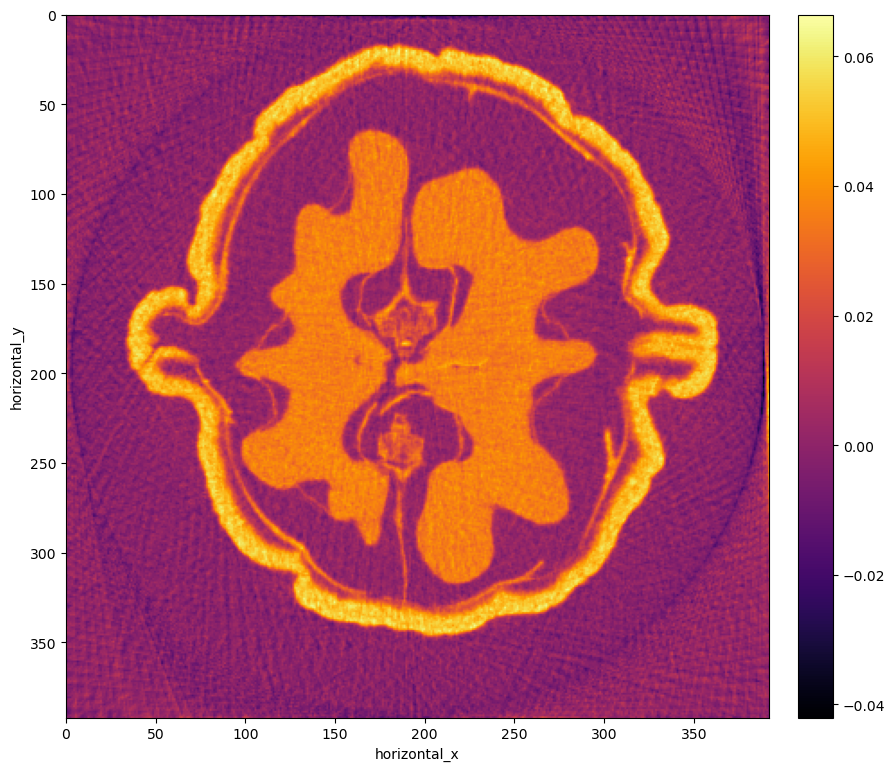

In [7]:
full_objective=LeastSquares(A, b=data)
myGD_LS = GD(initial=ig2D.allocate(0), 
             objective_function=full_objective, 
             step_size=0.001, 
             max_iteration=1000, 
             update_objective_interval=100)
myGD_LS.run(1000, verbose=1)

show2D(myGD_LS.solution, cmap="inferno", origin="upper")

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          6.90194e+03
      100       1000         0.011          3.05915e+01
      200       1000         0.011          2.24228e+01
      300       1000         0.011          2.08478e+01
      400       1000         0.011          2.08767e+01
      500       1000         0.011          2.00931e+01
      600       1000         0.011          1.98965e+01
      700       1000         0.011          1.97421e+01
      800       1000         0.011          2.03162e+01
      900       1000         0.011          1.98239e+01
     1000       1000         0.011          1.98027e+01
-------------------------------------------------------
     1000       1000         0.011          1.98027e+01
Stop criterion has been reached.



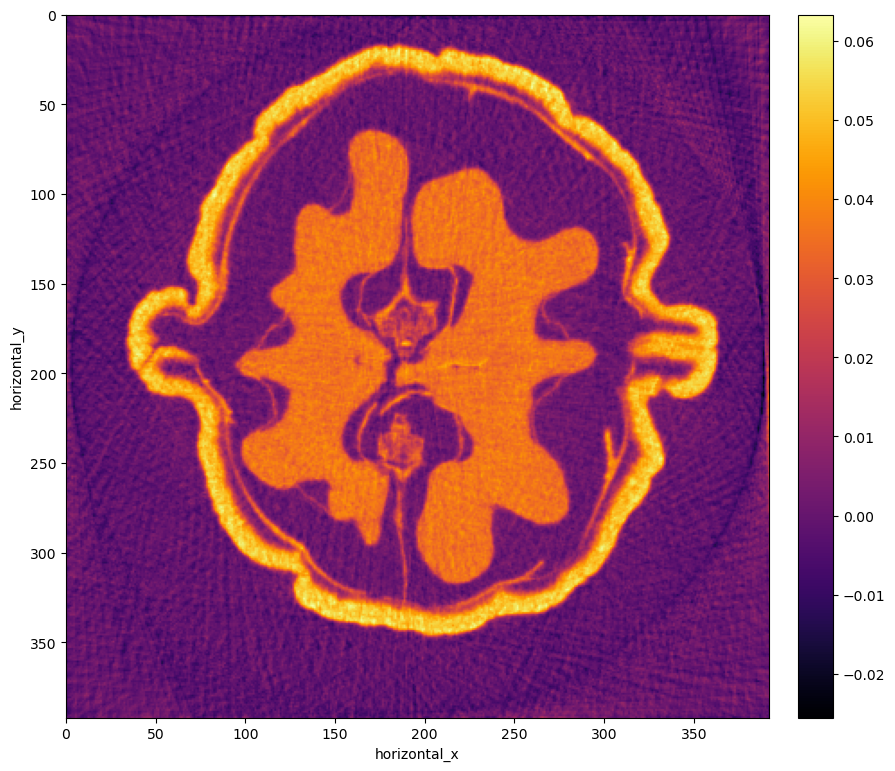

In [8]:
stochastic_objective=SGFunction(f_subsets,sampler)
mySGD_LS = GD(initial=ig2D.allocate(0), 
             objective_function=stochastic_objective, 
             step_size=0.001, 
             max_iteration=1000, 
             update_objective_interval=100)
mySGD_LS.run(1000, verbose=1)

show2D(mySGD_LS.solution, cmap="inferno", origin="upper")

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          6.90194e+03
      100       1000         0.034          3.01426e+01
      200       1000         0.035          3.01388e+01
      300       1000         0.034          3.01386e+01
      400       1000         0.035          3.01386e+01
      500       1000         0.035          3.01386e+01
      600       1000         0.035          3.01386e+01
      700       1000         0.035          3.01386e+01
      800       1000         0.035          3.01386e+01
      900       1000         0.035          3.01386e+01
     1000       1000         0.035          3.01386e+01
-------------------------------------------------------
     1000       1000         0.035          3.01386e+01
Stop criterion has been reached.



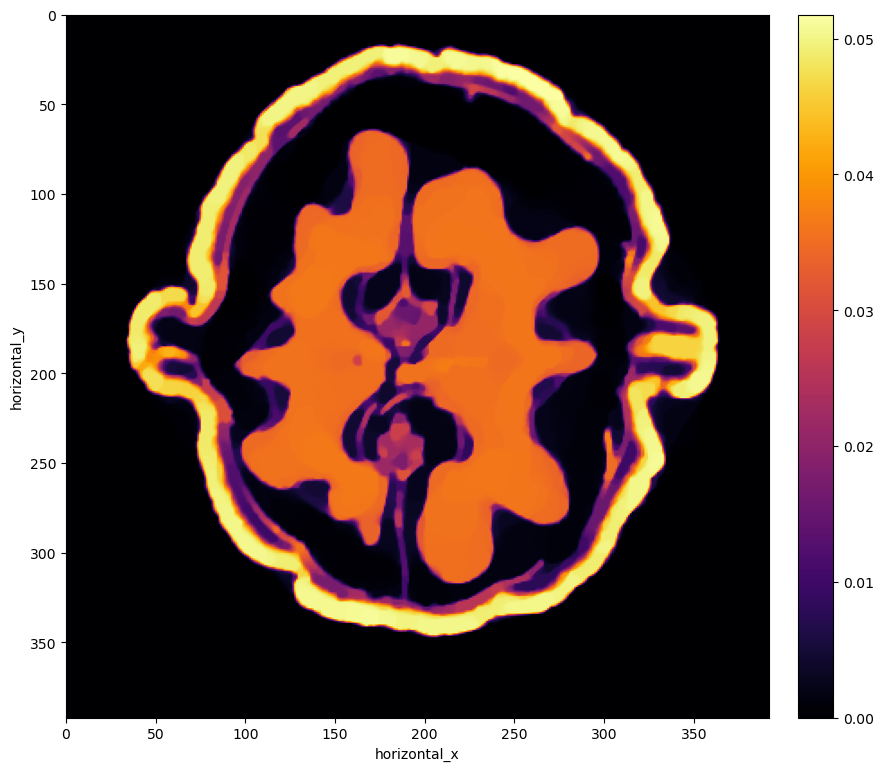

In [9]:
alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0)
F_FISTA = LeastSquares(A, b = data, c = 0.5)
step_size_fista = 1./F_FISTA.L
print(step_size_fista)
fista = FISTA(initial = initial, f=F_FISTA, step_size = step_size_fista, g=G, update_objective_interval = 100, 
            max_iteration = 1000)
fista.run(verbose=1)
optimal = fista.solution
show2D(fista.solution, cmap="inferno", origin="upper")

0.0019050877577049083
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       3000         0.000          6.90194e+03
      100       3000         0.030          6.27207e+01
      200       3000         0.029          1.74095e+02
      300       3000         0.028          1.84340e+02
      400       3000         0.028          2.04585e+02
      500       3000         0.028          1.98269e+02
      600       3000         0.028          1.98120e+02
      700       3000         0.028          1.74781e+02
      800       3000         0.028          2.22686e+02
      900       3000         0.028          2.12319e+02
     1000       3000         0.028          2.29640e+02
     1100       3000         0.027          2.50096e+02
     1200       3000         0.027          2.17208e+02
     1300       3000         0.027          2.05650e+02
     1400       3000         0.027          2.06997e+02
     1500       3000      

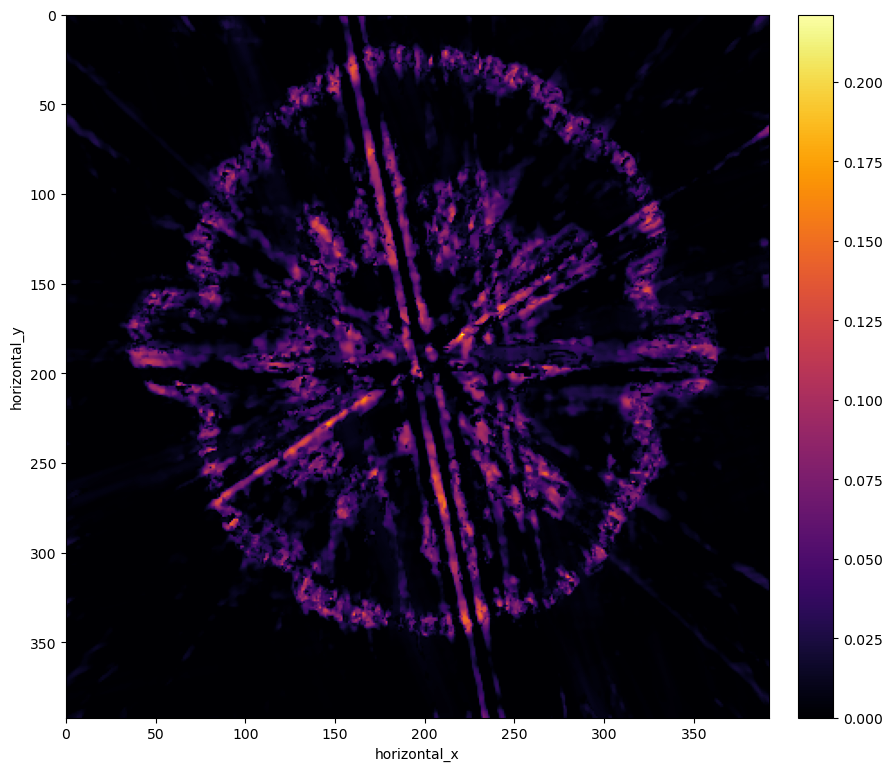

In [13]:
alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 
initial = ig2D.allocate(0)
F_FISTA_SG = SGFunction(f_subsets,sampler)
step_size_fista_SG= 1./F_FISTA_SG.L #FIXME: how to set this?? 
print(step_size_fista_SG)
fista_SG = FISTA(initial = initial, f=F_FISTA_SG, step_size = step_size_fista_SG, g=G, update_objective_interval = 100, 
            max_iteration = 3000)
fista_SG.run(verbose=1)
optimalSG = fista_SG.solution
show2D(fista_SG.solution, cmap="inferno", origin="upper")

In [12]:
print(step_size_fista_SG)

0.0019050877577049083


In [11]:
print(step_size_fista)

0.0019122750965919657
